### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt
import time

# Import the environment
from Env import CabDriver

#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

In [3]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [4]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01 
        self.epsilon = 1
        self.epsilon_max = 1
        self.epsilon_decay = -0.0005
        self.epsilon_min = 0.00001
        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)
        
        # for tracking states
        self.states_tracked = []

        # would track state [0,0,0] and action (0,2) 
        self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)
        
        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        input_shape = self.state_size
        
        # hidden layers
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model


    def get_action(self, state, possible_actions_index, actions):
    # Write your code here:
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment       
        if np.random.rand() <= self.epsilon:
            # lets choose a random action from the ride requests
            return random.choice(possible_actions_index)
        else:
            # Lets reshape state to (1, state_size) so that the first index corresponds to the batch size
            state = np.array(env.state_encod_arch1(state)).reshape(1, 36)

            # Lets predict the Q_values using model.
            q_value = self.model.predict(state)

            # check the q values whose requests are possible on given day and time
            possible_q_values = [q_value[0][i] for i in possible_actions_index]

            return possible_actions_index[np.argmax(possible_q_values)]
        
    def append_sample(self, state, action_index, reward, next_state, done):
        # Write your code here:
        # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action_index, reward, next_state, done))
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            
            #initialise the tow matrices - update_input and update_output
            update_input = np.zeros((self.batch_size, self.state_size))
            update_output = np.zeros((self.batch_size, self.state_size))
            actions, rewards, done = [], [], []

            #Lets populate the update_input/output, rewards, actions, done
            for i in range(self.batch_size):
                state, action, reward, next_state, done_val = mini_batch[i]
                update_input[i] = env.state_encod_arch1(state)     
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch1(next_state)
                done.append(done_val)

            #Lets predict the target q-values from states s
            target = self.model.predict(update_input)
            # target for q-network
            target_qval = self.model.predict(update_output)


            # update the target values
            for i in range(self.batch_size):
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else: 
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
            
            #fit the model
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
                
    def save_tracking_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_tracked.append(q_value[0][2])

    def save(self, name):
        self.model.save(name)

In [5]:
Episodes = 15000

In [6]:
m = 5
t = 24
d = 7

env = CabDriver()
action_space, state_space, state = env.reset()

# lets get state and action sizes.
state_size = m+t+d
action_size = len(action_space)

agent = DQNAgent(state_size, action_size)

# variables to store rewards in each episode
rewards_per_episode, episodes = [], []

episode_time = 24*30 #30 days before car would be recharged

### DQN block

In [7]:
start_time = time.time()
score_tracked = []

for episode in range(Episodes):

    done = False
    score = 0
    track_reward = False

    # total_time is variable to track the net hours cab is running in episode.
    total_time = 0 
    
    env = CabDriver()
    action_space, state_space, state = env.reset()
    
    # Lets save the initial state so that Reward can be tracked if initial state is [0,0,0]
    initial_state = env.state_init

    while not done:
        possible_actions_indices, actions = env.requests(state)
        
        # lets get the action using epsion greedy policy
        action = agent.get_action(state, possible_actions_indices, actions)

        # lets find the next state, reward, time taken for action from env using step function
        reward, next_state, step_time = env.step(state, env.action_space[action], Time_matrix)
        
        total_time += step_time
        if (total_time > episode_time):
            # if ride not complete in stipulated time, then skip and move to next episode.
            done = True
        else:
            # lets concatenate the experience to the memory
            agent.append_sample(state, action, reward, next_state, done)
            # Train the model
            agent.train_model()
            
            score += reward
            state = next_state

    rewards_per_episode.append(score)
    episodes.append(episode)
    
    # epsilon decay
    agent.epsilon = (1 - 0.00001) * np.exp(agent.epsilon_decay * episode)

    # every 10 episodes:
    if ((episode + 1) % 10 == 0):
        print("episode {0}, reward {1}, memory_length {2}, epsilon {3} total_time {4}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon, total_time))
    
    # Lets save the Q_value of the state, action pair which we are tracking
    if ((episode + 1) % 5 == 0):
        agent.save_tracking_states()

    # Total rewards per episode
    score_tracked.append(score)

    if(episode % 1000 == 0):
        #saving model and weights every 1000 episode
        print("Saving Model {}".format(episode))
        agent.model.save_weights("model_weights.h5")
        save_obj(agent.states_tracked, "model_weights.pkl")
    
elapsed_time = time.time() - start_time
print(elapsed_time)

Saving Model 0
episode 9, reward -506.0, memory_length 1343, epsilon 0.9955001547284723 total_time 728.0
episode 19, reward -100.0, memory_length 2000, epsilon 0.9905350769930761 total_time 724.0
episode 29, reward -52.0, memory_length 2000, epsilon 0.9855947626861951 total_time 728.0
episode 39, reward -291.0, memory_length 2000, epsilon 0.9806790882997144 total_time 731.0
episode 49, reward -297.0, memory_length 2000, epsilon 0.9757879309415182 total_time 726.0
episode 59, reward -18.0, memory_length 2000, epsilon 0.9709211683324178 total_time 725.0
episode 69, reward -110.0, memory_length 2000, epsilon 0.9660786788030947 total_time 723.0
episode 79, reward -187.0, memory_length 2000, epsilon 0.9612603412910584 total_time 727.0
episode 89, reward 24.0, memory_length 2000, epsilon 0.9564660353376199 total_time 724.0
episode 99, reward 8.0, memory_length 2000, epsilon 0.9516956410848808 total_time 721.0
episode 109, reward -387.0, memory_length 2000, epsilon 0.9469490392727365 total_ti

episode 909, reward 305.0, memory_length 2000, epsilon 0.6347589235987051 total_time 722.0
episode 919, reward 266.0, memory_length 2000, epsilon 0.631593050259626 total_time 726.0
episode 929, reward 179.0, memory_length 2000, epsilon 0.6284429667796988 total_time 721.0
episode 939, reward 347.0, memory_length 2000, epsilon 0.6253085944066726 total_time 728.0
episode 949, reward 71.0, memory_length 2000, epsilon 0.6221898547810748 total_time 728.0
episode 959, reward 371.0, memory_length 2000, epsilon 0.6190866699342522 total_time 728.0
episode 969, reward 428.0, memory_length 2000, epsilon 0.6159989622864221 total_time 730.0
episode 979, reward 145.0, memory_length 2000, epsilon 0.6129266546447325 total_time 721.0
episode 989, reward 713.0, memory_length 2000, epsilon 0.6098696702013323 total_time 726.0
episode 999, reward 122.0, memory_length 2000, epsilon 0.6068279325314512 total_time 726.0
Saving Model 1000
episode 1009, reward 131.0, memory_length 2000, epsilon 0.6038013655914889

episode 1799, reward 1063.0, memory_length 2000, epsilon 0.4067689276701942 total_time 726.0
episode 1809, reward 513.0, memory_length 2000, epsilon 0.40474015917966877 total_time 724.0
episode 1819, reward 308.0, memory_length 2000, epsilon 0.4027215092142031 total_time 723.0
episode 1829, reward 641.0, memory_length 2000, epsilon 0.4007129273074429 total_time 726.0
episode 1839, reward 674.0, memory_length 2000, epsilon 0.39871436324473586 total_time 732.0
episode 1849, reward 271.0, memory_length 2000, epsilon 0.3967257670618763 total_time 724.0
episode 1859, reward 906.0, memory_length 2000, epsilon 0.3947470890438561 total_time 723.0
episode 1869, reward 617.0, memory_length 2000, epsilon 0.3927782797236218 total_time 722.0
episode 1879, reward 369.0, memory_length 2000, epsilon 0.3908192898808378 total_time 723.0
episode 1889, reward 555.0, memory_length 2000, epsilon 0.388870070540656 total_time 725.0
episode 1899, reward 722.0, memory_length 2000, epsilon 0.38693057297249134 to

episode 2689, reward 629.0, memory_length 2000, epsilon 0.26066740358669477 total_time 721.0
episode 2699, reward 1080.0, memory_length 2000, epsilon 0.25936731948751673 total_time 721.0
episode 2709, reward 887.0, memory_length 2000, epsilon 0.2580737195848345 total_time 722.0
episode 2719, reward 998.0, memory_length 2000, epsilon 0.25678657153858325 total_time 722.0
episode 2729, reward 707.0, memory_length 2000, epsilon 0.2555058431699948 total_time 729.0
episode 2739, reward 666.0, memory_length 2000, epsilon 0.25423150246079323 total_time 725.0
episode 2749, reward 1051.0, memory_length 2000, epsilon 0.2529635175523944 total_time 724.0
episode 2759, reward 893.0, memory_length 2000, epsilon 0.25170185674510953 total_time 722.0
episode 2769, reward 806.0, memory_length 2000, epsilon 0.25044648849735274 total_time 723.0
episode 2779, reward 860.0, memory_length 2000, epsilon 0.2491973814248526 total_time 725.0
episode 2789, reward 732.0, memory_length 2000, epsilon 0.24795450429986

episode 3569, reward 929.0, memory_length 2000, epsilon 0.16787930169900972 total_time 727.0
episode 3579, reward 1152.0, memory_length 2000, epsilon 0.16704200018866794 total_time 724.0
episode 3589, reward 1122.0, memory_length 2000, epsilon 0.166208874737031 total_time 725.0
episode 3599, reward 1062.0, memory_length 2000, epsilon 0.1653799045159192 total_time 726.0
episode 3609, reward 1271.0, memory_length 2000, epsilon 0.16455506880103385 total_time 721.0
episode 3619, reward 1293.0, memory_length 2000, epsilon 0.1637343469714391 total_time 726.0
episode 3629, reward 897.0, memory_length 2000, epsilon 0.1629177185090465 total_time 721.0
episode 3639, reward 1055.0, memory_length 2000, epsilon 0.16210516299810185 total_time 723.0
episode 3649, reward 1069.0, memory_length 2000, epsilon 0.16129666012467522 total_time 722.0
episode 3659, reward 952.0, memory_length 2000, epsilon 0.16049218967615253 total_time 721.0
episode 3669, reward 1251.0, memory_length 2000, epsilon 0.159691731

episode 4449, reward 1400.0, memory_length 2000, epsilon 0.10812038464016717 total_time 725.0
episode 4459, reward 1157.0, memory_length 2000, epsilon 0.10758113197207911 total_time 728.0
episode 4469, reward 1500.0, memory_length 2000, epsilon 0.10704456883789358 total_time 725.0
episode 4479, reward 1556.0, memory_length 2000, epsilon 0.10651068182350425 total_time 727.0
episode 4489, reward 1292.0, memory_length 2000, epsilon 0.10597945758170793 total_time 723.0
episode 4499, reward 1578.0, memory_length 2000, epsilon 0.10545088283187094 total_time 729.0
episode 4509, reward 1256.0, memory_length 2000, epsilon 0.10492494435959693 total_time 721.0
episode 4519, reward 1455.0, memory_length 2000, epsilon 0.1044016290163968 total_time 726.0
episode 4529, reward 1562.0, memory_length 2000, epsilon 0.10388092371935967 total_time 721.0
episode 4539, reward 1121.0, memory_length 2000, epsilon 0.103362815450826 total_time 729.0
episode 4549, reward 1499.0, memory_length 2000, epsilon 0.1028

episode 5329, reward 1374.0, memory_length 2000, epsilon 0.0696334655697859 total_time 724.0
episode 5339, reward 883.0, memory_length 2000, epsilon 0.06928616721137094 total_time 729.0
episode 5349, reward 1503.0, memory_length 2000, epsilon 0.06894060101074495 total_time 728.0
episode 5359, reward 1411.0, memory_length 2000, epsilon 0.06859675832873488 total_time 725.0
episode 5369, reward 1422.0, memory_length 2000, epsilon 0.06825463056925578 total_time 727.0
episode 5379, reward 1233.0, memory_length 2000, epsilon 0.06791420917909581 total_time 721.0
episode 5389, reward 1175.0, memory_length 2000, epsilon 0.06757548564770255 total_time 725.0
episode 5399, reward 1062.0, memory_length 2000, epsilon 0.06723845150697004 total_time 721.0
episode 5409, reward 1359.0, memory_length 2000, epsilon 0.06690309833102723 total_time 729.0
episode 5419, reward 1531.0, memory_length 2000, epsilon 0.06656941773602718 total_time 725.0
episode 5429, reward 1468.0, memory_length 2000, epsilon 0.066

episode 6199, reward 1629.0, memory_length 2000, epsilon 0.045071281909517265 total_time 728.0
episode 6209, reward 1240.0, memory_length 2000, epsilon 0.04484648795318105 total_time 721.0
episode 6219, reward 1179.0, memory_length 2000, epsilon 0.04462281516137944 total_time 722.0
episode 6229, reward 1324.0, memory_length 2000, epsilon 0.044400257942280974 total_time 722.0
episode 6239, reward 1562.0, memory_length 2000, epsilon 0.04417881073194358 total_time 725.0
episode 6249, reward 1743.0, memory_length 2000, epsilon 0.04395846799417545 total_time 727.0
episode 6259, reward 1377.0, memory_length 2000, epsilon 0.043739224220396694 total_time 721.0
episode 6269, reward 1494.0, memory_length 2000, epsilon 0.04352107392950154 total_time 724.0
episode 6279, reward 1654.0, memory_length 2000, epsilon 0.04330401166772134 total_time 729.0
episode 6289, reward 747.0, memory_length 2000, epsilon 0.04308803200848826 total_time 729.0
episode 6299, reward 1356.0, memory_length 2000, epsilon 0

episode 7069, reward 1533.0, memory_length 2000, epsilon 0.029173048279943936 total_time 721.0
episode 7079, reward 1941.0, memory_length 2000, epsilon 0.029027547094634832 total_time 722.0
episode 7089, reward 1157.0, memory_length 2000, epsilon 0.02888277159951494 total_time 723.0
episode 7099, reward 1301.0, memory_length 2000, epsilon 0.028738718175189356 total_time 721.0
episode 7109, reward 1045.0, memory_length 2000, epsilon 0.028595383220314963 total_time 725.0
episode 7119, reward 1384.0, memory_length 2000, epsilon 0.02845276315151042 total_time 723.0
episode 7129, reward 1811.0, memory_length 2000, epsilon 0.028310854403266573 total_time 722.0
episode 7139, reward 1607.0, memory_length 2000, epsilon 0.028169653427857343 total_time 725.0
episode 7149, reward 1578.0, memory_length 2000, epsilon 0.028029156695250978 total_time 722.0
episode 7159, reward 1472.0, memory_length 2000, epsilon 0.027889360693021847 total_time 725.0
episode 7169, reward 1506.0, memory_length 2000, eps

episode 7939, reward 1779.0, memory_length 2000, epsilon 0.018882683382569338 total_time 723.0
episode 7949, reward 1404.0, memory_length 2000, epsilon 0.018788505606300788 total_time 722.0
episode 7959, reward 1435.0, memory_length 2000, epsilon 0.01869479754365095 total_time 721.0
episode 7969, reward 1803.0, memory_length 2000, epsilon 0.0186015568519134 total_time 725.0
episode 7979, reward 1003.0, memory_length 2000, epsilon 0.018508781200065983 total_time 723.0
episode 7989, reward 1563.0, memory_length 2000, epsilon 0.018416468268712564 total_time 722.0
episode 7999, reward 1584.0, memory_length 2000, epsilon 0.018324615750025048 total_time 721.0
Saving Model 8000
episode 8009, reward 1229.0, memory_length 2000, epsilon 0.018233221347685697 total_time 728.0
episode 8019, reward 1229.0, memory_length 2000, epsilon 0.018142282776829687 total_time 723.0
episode 8029, reward 910.0, memory_length 2000, epsilon 0.01805179776398801 total_time 725.0
episode 8039, reward 1721.0, memory_l

episode 8809, reward 1519.0, memory_length 2000, epsilon 0.012222093773158674 total_time 721.0
episode 8819, reward 1499.0, memory_length 2000, epsilon 0.012161135826156058 total_time 722.0
episode 8829, reward 1751.0, memory_length 2000, epsilon 0.01210048190818249 total_time 733.0
episode 8839, reward 1548.0, memory_length 2000, epsilon 0.01204013050288686 total_time 728.0
episode 8849, reward 1809.0, memory_length 2000, epsilon 0.011980080101480892 total_time 722.0
episode 8859, reward 1449.0, memory_length 2000, epsilon 0.011920329202701425 total_time 721.0
episode 8869, reward 1781.0, memory_length 2000, epsilon 0.011860876312772876 total_time 724.0
episode 8879, reward 1294.0, memory_length 2000, epsilon 0.011801719945369903 total_time 727.0
episode 8889, reward 1170.0, memory_length 2000, epsilon 0.011742858621580235 total_time 723.0
episode 8899, reward 1350.0, memory_length 2000, epsilon 0.011684290869867704 total_time 726.0
episode 8909, reward 1290.0, memory_length 2000, eps

episode 9679, reward 1546.0, memory_length 2000, epsilon 0.007910929457080072 total_time 725.0
episode 9689, reward 1303.0, memory_length 2000, epsilon 0.007871473531807663 total_time 726.0
episode 9699, reward 1356.0, memory_length 2000, epsilon 0.007832214393783524 total_time 722.0
episode 9709, reward 1195.0, memory_length 2000, epsilon 0.007793151061527156 total_time 722.0
episode 9719, reward 2160.0, memory_length 2000, epsilon 0.00775428255845322 total_time 721.0
episode 9729, reward 970.0, memory_length 2000, epsilon 0.007715607912847108 total_time 723.0
episode 9739, reward 1516.0, memory_length 2000, epsilon 0.007677126157840679 total_time 722.0
episode 9749, reward 1352.0, memory_length 2000, epsilon 0.007638836331388046 total_time 727.0
episode 9759, reward 1654.0, memory_length 2000, epsilon 0.007600737476241555 total_time 722.0
episode 9769, reward 1368.0, memory_length 2000, epsilon 0.007562828639927842 total_time 726.0
episode 9779, reward 1206.0, memory_length 2000, eps

episode 10539, reward 1595.0, memory_length 2000, epsilon 0.005146131559545177 total_time 723.0
episode 10549, reward 1616.0, memory_length 2000, epsilon 0.005120465121314752 total_time 726.0
episode 10559, reward 1812.0, memory_length 2000, epsilon 0.005094926694979046 total_time 721.0
episode 10569, reward 1347.0, memory_length 2000, epsilon 0.00506951564207608 total_time 725.0
episode 10579, reward 1445.0, memory_length 2000, epsilon 0.005044231327328204 total_time 727.0
episode 10589, reward 1501.0, memory_length 2000, epsilon 0.005019073118626231 total_time 726.0
episode 10599, reward 1269.0, memory_length 2000, epsilon 0.004994040387013635 total_time 733.0
episode 10609, reward 1813.0, memory_length 2000, epsilon 0.00496913250667082 total_time 723.0
episode 10619, reward 1667.0, memory_length 2000, epsilon 0.004944348854899481 total_time 724.0
episode 10629, reward 1437.0, memory_length 2000, epsilon 0.004919688812107034 total_time 724.0
episode 10639, reward 1794.0, memory_lengt

episode 11389, reward 1428.0, memory_length 2000, epsilon 0.003364385323933774 total_time 724.0
episode 11399, reward 1422.0, memory_length 2000, epsilon 0.0033476053821268207 total_time 721.0
episode 11409, reward 1460.0, memory_length 2000, epsilon 0.0033309091306287742 total_time 726.0
episode 11419, reward 1644.0, memory_length 2000, epsilon 0.0033142961520324795 total_time 722.0
episode 11429, reward 1749.0, memory_length 2000, epsilon 0.0032977660310126045 total_time 727.0
episode 11439, reward 1710.0, memory_length 2000, epsilon 0.0032813183543152643 total_time 721.0
episode 11449, reward 1321.0, memory_length 2000, epsilon 0.003264952710747684 total_time 728.0
episode 11459, reward 1724.0, memory_length 2000, epsilon 0.003248668691167922 total_time 725.0
episode 11469, reward 1623.0, memory_length 2000, epsilon 0.0032324658884746406 total_time 723.0
episode 11479, reward 1357.0, memory_length 2000, epsilon 0.0032163438975969265 total_time 727.0
episode 11489, reward 1698.0, mem

episode 12239, reward 1945.0, memory_length 2000, epsilon 0.0021995334703221957 total_time 723.0
episode 12249, reward 1832.0, memory_length 2000, epsilon 0.002188563251372572 total_time 721.0
episode 12259, reward 1288.0, memory_length 2000, epsilon 0.002177647746618221 total_time 722.0
episode 12269, reward 1744.0, memory_length 2000, epsilon 0.0021667866831709542 total_time 723.0
episode 12279, reward 1485.0, memory_length 2000, epsilon 0.00215597978950362 total_time 726.0
episode 12289, reward 1497.0, memory_length 2000, epsilon 0.0021452267954433146 total_time 723.0
episode 12299, reward 1622.0, memory_length 2000, epsilon 0.002134527432164626 total_time 722.0
episode 12309, reward 1853.0, memory_length 2000, epsilon 0.002123881432182913 total_time 721.0
episode 12319, reward 1661.0, memory_length 2000, epsilon 0.0021132885293476253 total_time 726.0
episode 12329, reward 1726.0, memory_length 2000, epsilon 0.002102748458835638 total_time 721.0
episode 12339, reward 1620.0, memory_

episode 13089, reward 1663.0, memory_length 2000, epsilon 0.0014379885242784493 total_time 722.0
episode 13099, reward 1332.0, memory_length 2000, epsilon 0.0014308165265929267 total_time 721.0
episode 13109, reward 1846.0, memory_length 2000, epsilon 0.0014236802993950906 total_time 722.0
episode 13119, reward 1557.0, memory_length 2000, epsilon 0.0014165796642788893 total_time 724.0
episode 13129, reward 1620.0, memory_length 2000, epsilon 0.0014095144437280755 total_time 728.0
episode 13139, reward 1523.0, memory_length 2000, epsilon 0.0014024844611117656 total_time 724.0
episode 13149, reward 2022.0, memory_length 2000, epsilon 0.0013954895406800313 total_time 721.0
episode 13159, reward 1374.0, memory_length 2000, epsilon 0.0013885295075594956 total_time 723.0
episode 13169, reward 1549.0, memory_length 2000, epsilon 0.001381604187748968 total_time 726.0
episode 13179, reward 1526.0, memory_length 2000, epsilon 0.001374713408115093 total_time 725.0
episode 13189, reward 1082.0, me

episode 13939, reward 1197.0, memory_length 2000, epsilon 0.0009401134485367081 total_time 728.0
episode 13949, reward 1558.0, memory_length 2000, epsilon 0.0009354246131508923 total_time 723.0
episode 13959, reward 1574.0, memory_length 2000, epsilon 0.0009307591634291251 total_time 724.0
episode 13969, reward 1729.0, memory_length 2000, epsilon 0.0009261169827349209 total_time 721.0
episode 13979, reward 1905.0, memory_length 2000, epsilon 0.0009214979550135194 total_time 723.0
episode 13989, reward 1440.0, memory_length 2000, epsilon 0.0009169019647889888 total_time 721.0
episode 13999, reward 1393.0, memory_length 2000, epsilon 0.0009123288971613334 total_time 724.0
Saving Model 14000
episode 14009, reward 1274.0, memory_length 2000, epsilon 0.0009077786378036242 total_time 722.0
episode 14019, reward 1620.0, memory_length 2000, epsilon 0.0009032510729591402 total_time 721.0
episode 14029, reward 1362.0, memory_length 2000, epsilon 0.0008987460894385246 total_time 722.0
episode 140

episode 14789, reward 1372.0, memory_length 2000, epsilon 0.0006146177672475235 total_time 721.0
episode 14799, reward 1928.0, memory_length 2000, epsilon 0.0006115523483448293 total_time 724.0
episode 14809, reward 1747.0, memory_length 2000, epsilon 0.0006085022182826951 total_time 727.0
episode 14819, reward 1705.0, memory_length 2000, epsilon 0.0006054673008077113 total_time 723.0
episode 14829, reward 1838.0, memory_length 2000, epsilon 0.0006024475200467823 total_time 727.0
episode 14839, reward 1845.0, memory_length 2000, epsilon 0.0005994428005052322 total_time 726.0
episode 14849, reward 1780.0, memory_length 2000, epsilon 0.0005964530670649156 total_time 724.0
episode 14859, reward 936.0, memory_length 2000, epsilon 0.0005934782449823409 total_time 727.0
episode 14869, reward 1397.0, memory_length 2000, epsilon 0.0005905182598868013 total_time 721.0
episode 14879, reward 1445.0, memory_length 2000, epsilon 0.0005875730377785148 total_time 729.0
episode 14889, reward 1339.0, m

In [8]:
#saving the final model and its weight
save_obj(agent.states_tracked, "model_weights.pkl")
agent.model.save_weights("model_weights.h5")

INFO:tensorflow:Assets written to: model_weights.pkl\assets


### Tracking Convergence

In [9]:
agent.states_tracked


[127.42051,
 227.69713,
 210.44629,
 355.56506,
 323.61597,
 763.01935,
 295.75955,
 273.9612,
 263.71375,
 257.81046,
 265.02094,
 273.28674,
 282.4121,
 294.22763,
 439.57404,
 346.46045,
 368.23145,
 452.0931,
 287.24567,
 255.24414,
 425.19598,
 614.2232,
 491.25974,
 418.6957,
 449.7456,
 318.40237,
 590.04474,
 398.6243,
 463.06717,
 386.1367,
 387.98425,
 361.91763,
 362.40784,
 509.309,
 379.20093,
 297.6084,
 367.81058,
 456.88196,
 440.9796,
 415.29922,
 574.8547,
 486.5539,
 436.79358,
 389.82196,
 351.469,
 431.75827,
 510.24628,
 493.94916,
 513.8941,
 409.1932,
 451.96753,
 396.33173,
 395.51685,
 494.79745,
 392.21423,
 487.86954,
 455.33746,
 395.86728,
 414.97388,
 389.76306,
 506.05203,
 478.46973,
 494.5278,
 356.0119,
 414.4725,
 488.8171,
 480.27673,
 457.76666,
 443.40063,
 436.49265,
 525.1941,
 594.2137,
 548.102,
 515.35345,
 459.552,
 560.79486,
 414.8192,
 402.4872,
 487.79276,
 405.81067,
 412.13736,
 396.1032,
 412.32626,
 439.41113,
 406.57004,
 456.99677,

In [10]:

state_tracked_sample = [agent.states_tracked[i] for i in range(len(agent.states_tracked)) if agent.states_tracked[i] < 1000]

#### Lets plot the Q-Value convergence for state action pairs

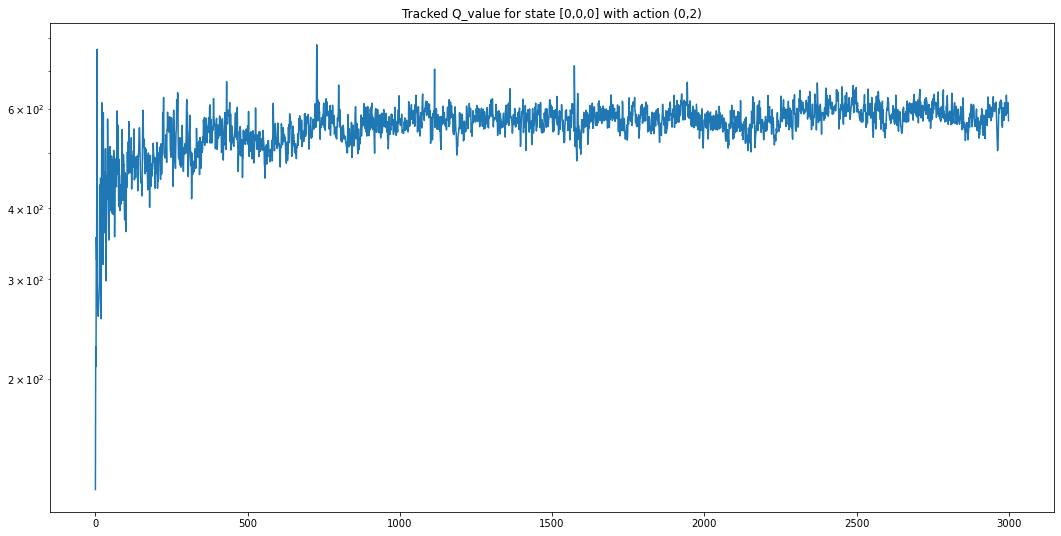

In [11]:
plt.figure(0, figsize=(18,9))
plt.title('Tracked Q_value for state [0,0,0] with action (0,2)')
x_axis = np.asarray(range(0, len(agent.states_tracked)))
plt.semilogy(x_axis,np.asarray(agent.states_tracked))
plt.show()

#### Lets track the rewards per episode

In [12]:
sample_score_tracked = [score_tracked[i] for i in range(len(score_tracked)) if (i % 4 == 0)]

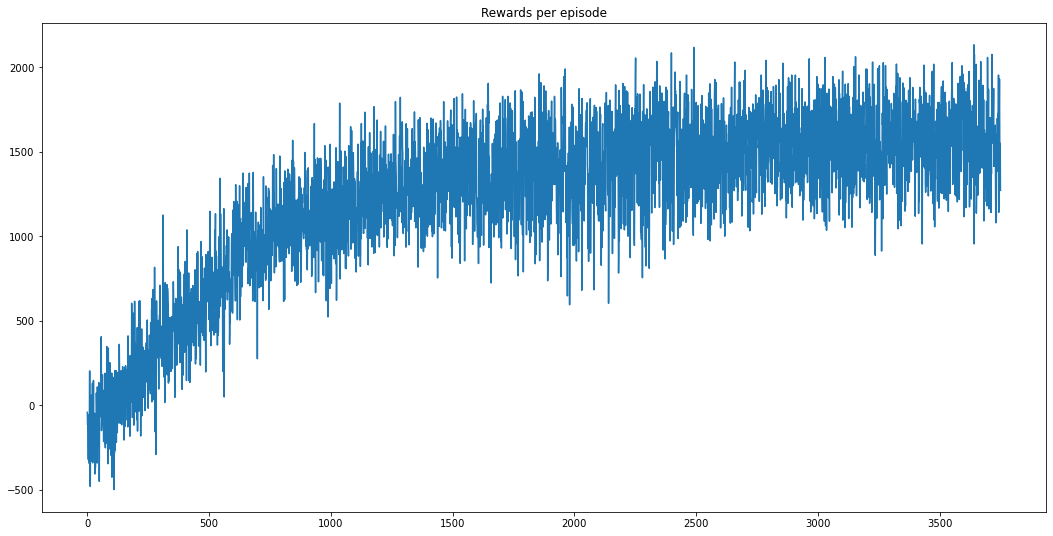

In [13]:
plt.figure(0, figsize=(18,9))
plt.title('Rewards per episode')
x_axis = np.asarray(range(0, len(sample_score_tracked)))
plt.plot(x_axis,np.asarray(sample_score_tracked))
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [14]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

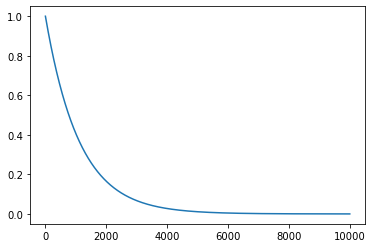

In [15]:
plt.plot(time, epsilon)
plt.show()